# Helium TLA Independent Check

In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

## Initialization

In [10]:
import numpy as np

%matplotlib inline

import matplotlib
matplotlib.rc_file('matplotlibrc')
matplotlib.rcParams['figure.figsize'] = [10,10]
import matplotlib.pyplot as plt
import darkhistory.physics as phys

from scipy.integrate import odeint

## Cosmological Parameters

In [3]:
# Default RECFAST 1.5.2 Parameters

Omega_B = 0.022032
Omega_M = Omega_B + 0.12038
Omega_CDM = Omega_M - Omega_B
Omega_rad = 8e-5
T_CMB_0 = 2.725*phys.kB
H0 = 67.556*3.241e-20
Y_p = 0.246
chi = Y_p/(1-Y_p)/3.9715


def TCMB(rs):
    
    return T_CMB_0*rs

def hubble(rs):
    
    return H0*np.sqrt(Omega_M*rs**3 + Omega_rad*rs**4)

In [4]:
# File Comparison

from astropy.io import fits
from scipy.interpolate import interp1d

# Compare with IDL results for Hionfraction and Heionfraction
direc = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/ref_files/z_3000_phot_decay_recfast/'

hdul = fits.open(
    direc
    +'tf_z_3.000E+03_nstep_6398_logE_1.230E+01_xe_0.000E+00.fits'
)

data = hdul[1].data

idl_redshift = data.field('redshift')[0]
xH_idl = data.field('hionfraction')[0]
xHe_idl = data.field('heionfraction')[0]

hdul.close()

xH_idl_func = interp1d(idl_redshift, xH_idl, bounds_error=False, fill_value=(xH_idl[-1], xH_idl[0]))
xHe_idl_func = interp1d(idl_redshift, xHe_idl, bounds_error=False, fill_value=(xHe_idl[-1], xHe_idl[0]))

In [5]:
f_He = chi
        
lambda_HeI_21p = 58.4334e-9*100 # cm
lambda_HeI_21s = 60.1404e-9*100 # cm

lambda_HeI_23p = 1/1.690871466e7 * 100 # cm, from CLASS
lambda_HeI_23s = 1/1.5985597526e7 * 100 # cm, from CLASS

E_ps = (2*np.pi*phys.hbar)*phys.c*(1/lambda_HeI_21p - 1/lambda_HeI_21s) # eV
E_ps_triplet = (2*np.pi*phys.hbar)*phys.c*(1/lambda_HeI_23p - 1/lambda_HeI_23s) # eV

E_ion_from_21s = phys.He_ion_eng - (2*np.pi*phys.hbar)*phys.c/lambda_HeI_21s
E_ion_from_23s = phys.He_ion_eng - (2*np.pi*phys.hbar)*phys.c/lambda_HeI_23s


def alpha_HeI(T):
    # Takes T in eV.
    
    q   = 10**(-16.744)
    T_2 = 3 # K
    T_1 = 10**(5.114) # K
    p   = 0.711
    
    T_in_K = T/phys.kB
    
    denom = np.sqrt(T_in_K/T_2) * (1 + T_in_K/T_2)**(1-p) * (1 + T_in_K/T_1)**(1+p)
    
    return q/denom * (100**3) # in cm^3 s^-1

def beta_HeI(T):
    
    fac = (2*np.pi*phys.me*T/(2*np.pi*phys.hbar*phys.c)**2)**(3/2)
    boltz = np.exp(-E_ion_from_21s/T)
    return 4*alpha_HeI(T)*fac*boltz

def alpha_HeI_triplet(T):
    
    q = 10**(-16.306)
    T_2 = 3 # in K
    T_1 = 10**(5.114)
    p = 0.761
    
    T_in_K = T/phys.kB
    
    denom = np.sqrt(T_in_K/T_2) * (1 + T_in_K/T_2)**(1-p) * (1 + T_in_K/T_1)**(1+p)
    
    return q/denom * (100**3) # in cm^3 s^-1

def beta_HeI_triplet(T):
    
    fac = (2*np.pi*phys.me*T/(2*np.pi*phys.hbar*phys.c)**2)**(3/2)
    boltz = np.exp(-E_ion_from_23s/T)
    return (4/3)*alpha_HeI_triplet(T)*fac*boltz

def xe_Saha(rs):
    
    T = TCMB(rs)
    
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * phys.me * T)
    )
    
    rhs = 4 * (1/de_broglie_wavelength)**3 / (phys.nH*rs**3) * np.exp(-phys.He_ion_eng/T)
    a = 1.
    b = -rhs*(-1.) - 1
    c = -(1 + chi)*rhs
    
    return (-b + np.sqrt(b**2 - 4*a*c))/(2*a)

def dxHeII_dz(xHeII, rs):
    
    xe = 1. + xHeII
    
    def C_HeII(xHeII, rs):
        
        T = TCMB(rs)
        xp = xH_idl_func(rs)
        A_2p = 1.798287e9
        
        tauHe = 3*A_2p*phys.nH*rs**3*(f_He - xHeII) * (lambda_HeI_21p**3)/(8*np.pi*hubble(rs))
        
        pHe_s = (1. - np.exp(-tauHe))/tauHe
        
        gamma_numer = 3*A_2p*(f_He - xHeII)*lambda_HeI_21p**2
        sigma = phys.photo_ion_xsec(2*np.pi*phys.hbar*phys.c/lambda_HeI_21p, 'HI')
        Delta_nu = (phys.c/lambda_HeI_21p)*np.sqrt(2*T/(3.9715*phys.mp))
        gamma_denom = 8*np.pi**(3/2)*sigma*Delta_nu*(1 - xp)
        if xp >= 1:
            gamma = np.inf
        else:
            gamma = gamma_numer/gamma_denom
        
        aHe = 0.36
        bHe = 0.86
#         bHe = 1.2
        p_con_H = 1/(1 + aHe*gamma**bHe)
        K_HeI = (1/3)/(A_2p * (pHe_s + p_con_H) * phys.nH*rs**3*(f_He - xHeII))
        
# #         tauHe_s = 3*A_2p*preco->CK_He*3.*n_He*(1.-x_He)/Hz;
# #         pHe_s = (1.-exp(-tauHe_s))/tauHe_s;
# #         K_He = 1./(_A2P_s_*pHe_s*3.*n_He*(1.-x_He))
        
#         K_HeI = (lambda_HeI_21p**3)/(8*np.pi*hubble(rs)) #cm^3 s
        
        Lambda_HeI = 51.3 #s^-1
        
        numer = 1 + K_HeI*Lambda_HeI*(phys.nH*rs**3)*(f_He - xHeII)*np.exp(E_ps/T)
        denom = 1 + K_HeI*(Lambda_HeI + beta_HeI(T))*(phys.nH*rs**3)*(f_He - xHeII)*np.exp(E_ps/T)
        
        return numer/denom
    
    def C_HeII_triplet(xHeII, rs):
        
        T = TCMB(rs)
        
        A_2p_triplet = 177.58
        
        tauHe_t = 3*A_2p_triplet*phys.nH*rs**3*(f_He - xHeII) * (lambda_HeI_23p**3)/(8*np.pi*hubble(rs))
        pHe_t = (1. - np.exp(-tauHe_t))/tauHe_t
        
        CfHe_t = A_2p_triplet*pHe_t*np.exp(-E_ps_triplet/T);
        CfHe_t = CfHe_t/(beta_HeI_triplet(T) + CfHe_t)
        
        return CfHe_t
    
    time_fac = 1/(hubble(rs)*rs)
    
    term_recomb = xHeII * xe * (phys.nH * rs**3) * alpha_HeI(TCMB(rs))
    term_ion    = beta_HeI(TCMB(rs)) * (f_He - xHeII) * np.exp(-(2*np.pi*phys.hbar*phys.c/lambda_HeI_21s)/TCMB(rs))
    
    term_recomb_triplet = xHeII * xe * (phys.nH * rs**3) * alpha_HeI_triplet(TCMB(rs))
    term_ion_triplet    = 3*beta_HeI_triplet(TCMB(rs)) * (f_He - xHeII) * np.exp(-(2*np.pi*phys.hbar*phys.c/lambda_HeI_23s)/TCMB(rs))
    
#     print('diagnoses start...')
#     print(C_HeII(xHeII, rs))
#     print(C_HeII_triplet(xHeII, rs))
#     print(time_fac)
#     print(term_recomb)
#     print(term_ion)
#     print('diagnoses end.')
    
    if xHeII > 0.99*chi:
        
        from scipy.misc import derivative
        
        return derivative(xe_Saha, rs)
    
    return (
        C_HeII(xHeII, rs) * time_fac * (term_recomb - term_ion)
        + C_HeII_triplet(xHeII, rs) * time_fac *(term_recomb_triplet - term_ion_triplet)
    )
        
        
        

In [6]:
%autoreload

init_cond = chi
rs_vec = np.arange(3000, 1400, -0.2)
soln = odeint(dxHeII_dz, init_cond, rs_vec, mxstep=0)

soln = soln.flatten()

[1600, 3000, 0.99, 1.09]

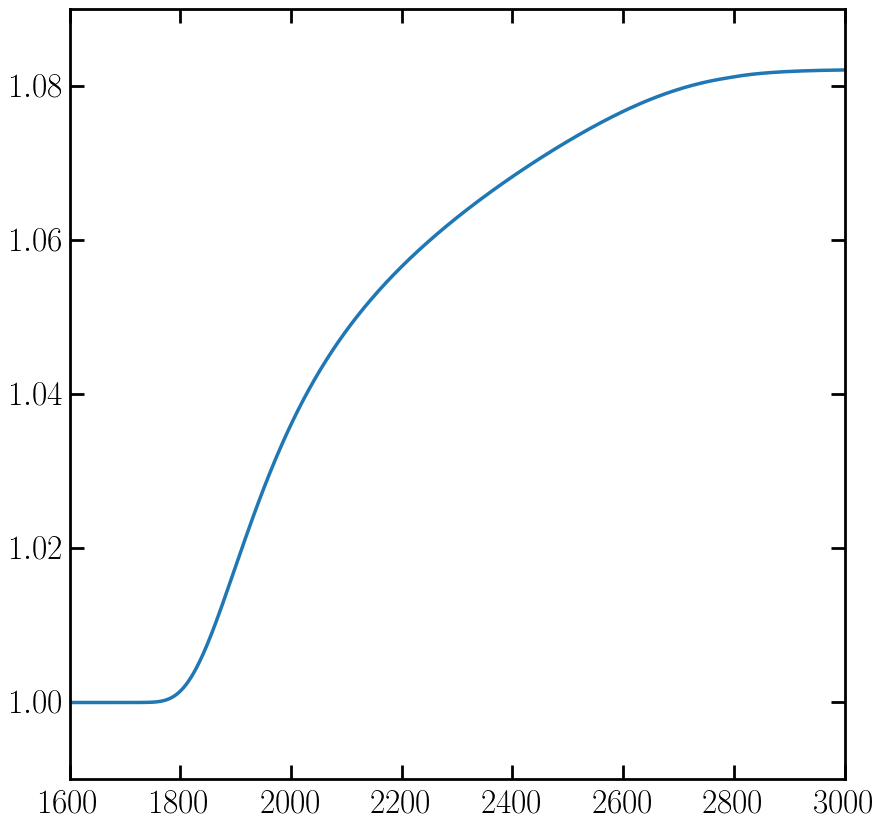

In [12]:
plt.figure()

plt.plot(rs_vec, soln+1)
# plt.plot(rs_vec, xHe_idl_func(rs_vec)*chi+1)
# plt.plot(rs_vec, xe_Saha(rs_vec))

plt.axis([1600, 3000, .99, 1.09])

In [14]:
a = np.loadtxt('/Users/hongwan/Recfast/recfast_1_5_2_planck.txt')
z_recfast = a[:,0]
xe_recfast = a[:,1]

ValueError: could not convert string to float: 'z'

In [ ]:
plt.figure()

ax = plt.gca()

# ax.loglog()

ax.set_yscale('log')

# plt.plot(rs_vec, soln+1)
plt.plot(1+z_recfast, xH_idl_func(1+z_recfast))
# plt.plot(z_recfast, xe_recfast)
plt.axis([0, 2000, 0, 1.1])
# plt.axis([1000, 3000, 0, 0.09])